In [1]:
from pathlib import Path
from typing import cast

import matplotlib
import matplotlib.pyplot as plt
import torch
from lightning.pytorch import seed_everything
from shimmer.modules.global_workspace import (
    GlobalWorkspaceFusion,
)
from simple_shapes_dataset import (
    SimpleShapesDataModule,
    get_default_domains,
)
from tokenizers.implementations.byte_level_bpe import ByteLevelBPETokenizer
from torchvision.utils import make_grid

from shimmer_ssd import DEBUG_MODE, PROJECT_DIR
from shimmer_ssd.config import DomainModelVariantType, LoadedDomainConfig, load_config
from shimmer_ssd.dataset.pre_process import TokenizeCaptions
from shimmer_ssd.logging import batch_to_device
from shimmer_ssd.modules.domains import load_pretrained_domains
from shimmer_ssd.modules.domains.visual import VisualLatentDomainModule

matplotlib.use("ipympl")

In [2]:
seed = 0
dataset_path = ""

seed_everything(seed, workers=True)

# Let's define the proportion of each groups of domain.
# Here, we say that we will use 100% of unimodal text domain samples
# 100% of the unimodal visual samples
# and 100% of the paired text-visual samples.
domain_proportion = {
    frozenset(["t"]): 1.0,
    frozenset(["v"]): 1.0,
    frozenset(["t", "v"]): 1.0,
}

# Then we get the data domain that will load the data for our two different domain
# formats:
# - `t` will load the text (with bert representations of the sentences
# - `v_latents` will load pre-saved latent representations of the visual VAE.
# You could also use `v` to load the images directly. Using `v_latents` will provide
# faster training as we can skip the VAE encoding.
domain_classes = get_default_domains(["v_latents", "t"])

# Let's define the locations of the `vocab.json` and `merges.txt` files for the
# text tokenizer.
vocab_path = "/home/bdevillers/projects/shimmer-ssd/tokenizer/vocab.json"
merges_path = "/home/bdevillers/projects/shimmer-ssd/tokenizer/merges.txt"
seq_length = 64  # we will use a sequence length of 64

# And define a transform for the text domain to tokenize the text string
additional_transforms = {"t": [TokenizeCaptions(vocab_path, merges_path, seq_length)]}
tokenizer = ByteLevelBPETokenizer(vocab_path, merges_path)

# here are some additional arguments used by the data domain classes
domain_data_args = {
    # where to load the pre-saved latent reprensentations
    "v_latents": {"presaved_path": "vae_v_shimmer.npy"},
    # bert model to use
    "t": {"latent_filename": "bert-base-uncased"},
}

batch_size = 1024

# initilize the lightning data module
data_module = SimpleShapesDataModule(
    config.dataset.path,
    domain_classes,
    domain_proportion,
    batch_size,
    seed=seed,
    domain_args=domain_data_args,
    additional_transforms=additional_transforms,
    max_train_size=500_000,
)

# We need to load pretrained unimodal domains.
# Here we define where are stored the domain checkpoints.
domains = [
    LoadedDomainConfig(
        domain_type=DomainModelVariantType.v_latents,
        checkpoint_path=Path(
            "/home/bdevillers/projects/shimmer-ssd/checkpoints/pretrained/domain_v.ckpt"
        ),
    ),
    LoadedDomainConfig(
        domain_type=DomainModelVariantType.t,
        checkpoint_path=Path(
            "/home/bdevillers/projects/shimmer-ssd/checkpoints/pretrained/domain_t.ckpt"
        ),
    ),
]

global_workspace_dim = 16
encoders_hidden_dim = 32
encoders_n_layers = 3
decoders_hidden_dim = 32
decoders_n_layers = 3

# we load the pretrained domain modules and define the associated GW encoders and
# decoders
domain_modules, gw_encoders, gw_decoders = load_pretrained_domains(
    domains,
    global_workspace_dim,
    encoders_hidden_dim,
    encoders_n_layers,
    decoders_hidden_dim,
    decoders_n_layers,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# And now we load the GW checkpoint
checkpoint = "/home/bdevillers/projects/shimmer-ssd/checkpoints/shimmer-simple-shapes-caer5sh9/epoch=1232.ckpt"
global_workspace = GlobalWorkspaceFusion.load_from_checkpoint(
    checkpoint,
    domain_mods=domain_modules,
    gw_encoders=gw_encoders,
    gw_decoders=gw_decoders,
)
global_workspace.to(device)

# Extract the `v_latents` domain module
visual_module = cast(
    VisualLatentDomainModule, global_workspace.domain_mods["v_latents"]
)

Seed set to 0
/home/bdevillers/.cache/pypoetry/virtualenvs/shimmer-ssd-s1RBJB6U-py3.11/lib/python3.11/site-packages/lightning/pytorch/core/saving.py:191: Found keys that are in the model state dict but not in the checkpoint: ['logit_scale']


In [3]:
# Let's get 32 samples from our dataset
train_samples = data_module.get_samples("train", 32)
train_samples = batch_to_device(train_samples, device)
print(train_samples.keys())

dict_keys([frozenset({'v_latents'}), frozenset({'t'}), frozenset({'t', 'v_latents'})])


This contains three groups: 2 unimodal data groups, and one paired group.
This corresponds to the groups defined in `domain_proportions`.
<div class="alert alert-info">
NOTE:
This is only the case for the train split. The train and test splits only have the paired data group as everything is paired.   
</div>

In the following, we will focus on the paired data:

In [4]:
train_paired_samples = train_samples[frozenset(["v_latents", "t"])]
print(train_paired_samples.keys())

dict_keys(['v_latents', 't'])


This group contains two items: one of each domain. Each item in the domain is paired
Let's look at the images first.

In [5]:
# `train_paired_samples` contains the latent representation, we can use `decode_images`
# of the visual module to get back the actual images:
train_images = visual_module.decode_images(train_paired_samples["v_latents"])


def plot_image_grid(samples: torch.Tensor, nrow=4):
    grid = (
        make_grid(samples, nrow=nrow, pad_value=1)
        .permute(1, 2, 0)
        .detach()
        .cpu()
        .numpy()
    )
    plt.imshow(grid)
    plt.show()

In [6]:
train_paired_samples["v_latents"].size()

torch.Size([32, 13])

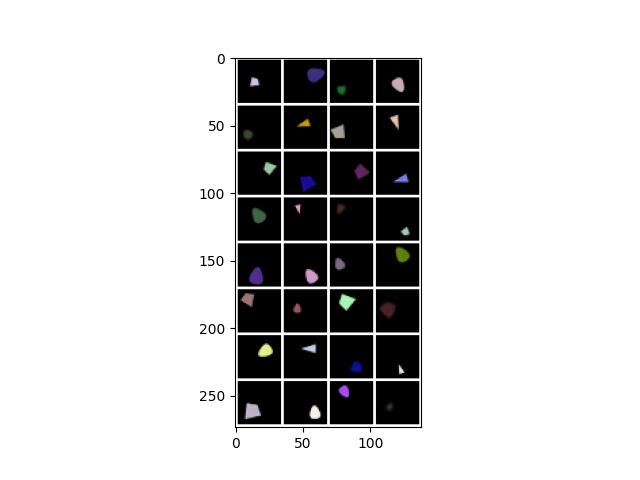

In [7]:
plot_image_grid(train_images)

In [8]:
train_paired_samples["t"]

{'bert': tensor([[-0.0295,  0.4828, -0.6249,  ..., -0.6715, -0.0847,  0.2428],
         [-0.3529, -0.1964,  0.5454,  ..., -1.8058,  0.5423, -0.9121],
         [ 0.8766, -0.1070,  1.7887,  ...,  1.1233,  0.4867, -0.1705],
         ...,
         [-1.9229,  2.2754, -2.2220,  ...,  1.3829, -2.1496,  0.0222],
         [-0.3343, -0.1584,  1.2444,  ..., -0.7224,  0.3656,  1.3582],
         [ 1.2014,  0.4460,  0.0669,  ...,  0.9270,  0.4732, -0.1380]],
        device='cuda:0'),
 'tokens': tensor([[314, 346, 436,  ...,   0,   0,   0],
         [428, 265, 261,  ...,   0,   0,   0],
         [314, 346, 265,  ...,   0,   0,   0],
         ...,
         [429, 265, 261,  ...,   0,   0,   0],
         [295, 265, 261,  ...,   0,   0,   0],
         [ 35, 358, 383,  ...,   0,   0,   0]], device='cuda:0')}

In [9]:
def get_text_samples(samples: dict[str, torch.Tensor]) -> list[str]:
    return tokenizer.decode_batch(
        samples["tokens"].detach().cpu().tolist(),
        skip_special_tokens=True,
    )

In [10]:
train_text_samples = get_text_samples(train_paired_samples["t"])
for k, text in enumerate(train_text_samples, 1):
    print(k, text.replace("<pad>", ""))

1 The image contains a thistle colored tiny arrow-shaped polygon. It is in the middle, slightly left. It is pointing towards the southwest.
2 This is a big dark slate blue colored egg, it is located at the upper side right side, it is pointing to the right.
3 The image is a tiny forest green colored object located at the bottom left side, and is pointing towards the northeast, and it looks like a trapezoidal shape.
4 The image contains a medium sized object in silver pointing towards the south-southeast, and is located slightly lower side, at the center, it looks like a guitar pick.
5 It is a tiny dark slate grey object at the bottom, on the left side and is pointing northwest. It looks like an oval shaped structure.
6 A small dark goldenrod isosceles triangle, and is at the middle, and is pointing to the west-southwest.
7 The image contains a medium dark grey trapezoidal shape and it is pointing towards the top-right corner and it is at the bottom, at the left.
8 This is an average si

In [11]:
latent_unimodal_text = global_workspace.encode_domain(train_paired_samples["t"], "t")
print(latent_unimodal_text.size())

torch.Size([32, 64])


In [12]:
t_gw_latent = global_workspace.gw_mod.encode({"t": latent_unimodal_text})
print(t_gw_latent["t"].size())
t_gw_latent_fused = global_workspace.gw_mod.fuse(
    t_gw_latent, {"t": torch.ones(32).to(device)}
)
print(t_gw_latent_fused.size())

torch.Size([32, 16])
torch.Size([32, 16])


In [13]:
decoded_latents = global_workspace.gw_mod.decode(
    t_gw_latent_fused, domains=["v_latents"]
)

In [14]:
decoded_latents["v_latents"].size()

torch.Size([32, 12])

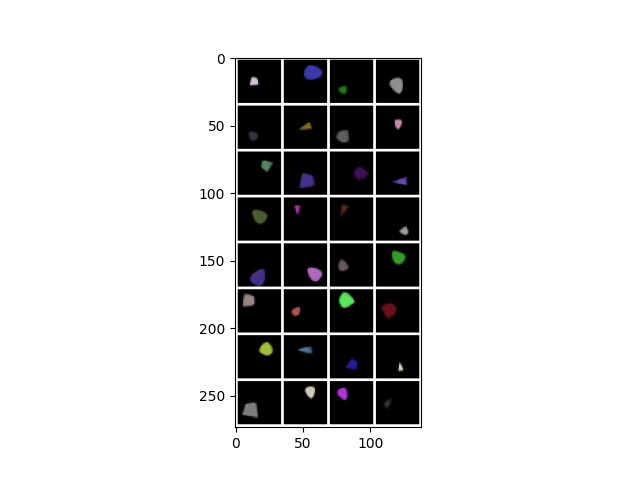

In [15]:
decoded_images = visual_module.decode_images(
    decoded_latents["v_latents"], remove_last_dim=False
)
plot_image_grid(decoded_images)


In [16]:
latent_unimodal_images = global_workspace.encode_domains(train_samples)

In [20]:
t_ = frozenset(["t"])
unimodal_train_samples = {t_: train_samples[t_]}
latent_unimodal_images = global_workspace.encode_domains(unimodal_train_samples)
print(latent_unimodal_images.keys())
gw_latents = global_workspace.encode(latent_unimodal_images)
gw_latents_fused = global_workspace.fuse(
    gw_latents, {t_: {"t": torch.ones(32).to(device)}}
)
decoded_latents = global_workspace.decode(gw_latents_fused)
reconstructed_domains = global_workspace.decode_domains(decoded_latents)
reconstructed_texts = reconstructed_domains[t_]["t"]

dict_keys([frozenset({'t'})])


In [21]:
reconstructed_texts.keys()

dict_keys(['token_dist', 'tokens'])

In [22]:
reconstructed_text_strings = get_text_samples(reconstructed_texts)
for k, text in enumerate(reconstructed_text_strings, 1):
    print(k, text.replace("<pad>", ""))


1 The image contains a thistle tiny arrow-shaped polygon, and it is pointing towards the bottom-left, and it is located in the middle, slightly left.
2 The image is a large slate blue colored shape pointing to the right side, and is located at the upper side right side, and looks like a bullet.
3 This is a tiny forest green colored object pointing towards the northeast, and is located at the bottom left side, and looks like a four-sided shape.
4 The image contains a medium sized silver colored object pointing towards the south-southeast, and it is located slightly lower side, in the middle, it looks like a bullet.
5 There is a tiny dark slate grey object pointing to the northwest, it is at the bottom, on the left side, and looks like a bullet.
6 A kind of small shape in dark goldenrod color pointing to the west-southwest, and is located at the center, and looks like an isosceles triangle.
7 The image contains a medium sized dark grey colored shape pointing towards the top-right corner,